# ARIMA Models 
(Core)


*Christina Brockway*

Using the following data:
https://drive.google.com/file/d/1KKR8TZbkixVN2NundM2mEVv5AhjHhs9a/view?usp=sharing

*  Using Data from Walmart stock from 2010 to 2020 predict the Adjusted Close values for the next quarter
*  Fit an ARIMA model
*  Evaluate the model
*  Choose a final model and explain why

### Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)


In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax



In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics


In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig


In [6]:
# load in stock data
ts = pd.read_csv('data/WMT.csv', parse_dates=['Date'], index_col = 'Date')
ts.head(2)

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756


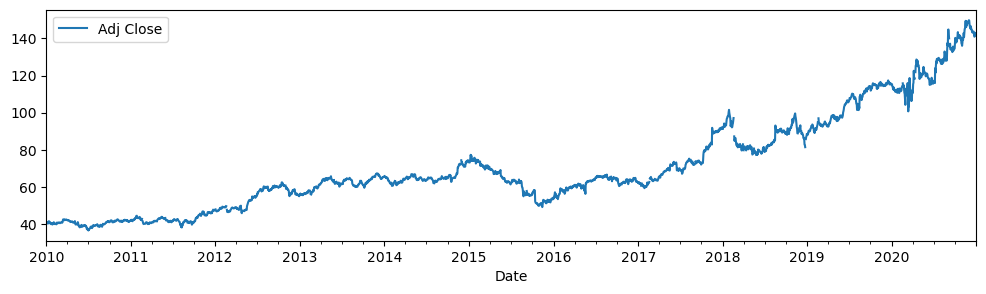

In [7]:
# Filter for 2015-2019 and only the adj close value
ts = ts.loc['2010':'2020']
ts.plot();

In [8]:
ts.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

In [9]:
# Resample for business day with 'B'
ts = ts.resample('B').asfreq()
ts

,Adj Close
Date,
2010-01-01,NaN
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


### Impute Nulls

In [10]:
#Check for nulls
ts.isna().sum()

Adj Close    101
dtype: int64

In [11]:
#Inspect null values
#Source: https://datatofish.com/rows-with-nan-pandas-dataframe/
null = ts[ts['Adj Close'].isna()]
print(null)

            Adj Close
Date                 
2010-01-01        NaN
2010-01-18        NaN
2010-02-15        NaN
2010-04-02        NaN
2010-05-31        NaN
...               ...
2020-05-25        NaN
2020-07-03        NaN
2020-09-07        NaN
2020-11-26        NaN
2020-12-25        NaN

[101 rows x 1 columns]


*  The null values are US Holidays. Stock prices do not change on those days
      *  Will use ffill to impute

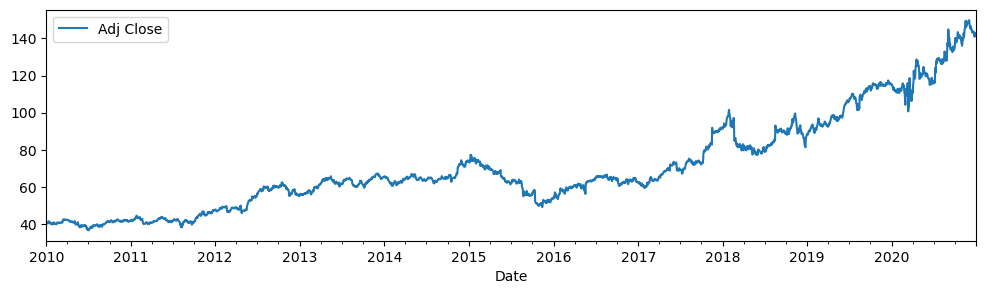

In [12]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();

In [13]:
ts.isna().sum()

Adj Close    1
dtype: int64

In [14]:
null = ts[ts['Adj Close'].isna()]
print(null)

            Adj Close
Date                 
2010-01-01        NaN


*  Jan 1,2010 cannot ffill so we will drop this column

In [15]:
ts= ts.dropna()
ts.isna().sum()

Adj Close    0
dtype: int64

### Check for Stationarity

In [16]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


** This data does not have stationarity**
    - Will difference data

### Determine How Much to Difference Data

In [41]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')


d is 1


In [19]:
tsdiff = ts.diff().dropna()
get_adfuller_results(tsdiff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.215558,22,2845,0.0,0.05,True


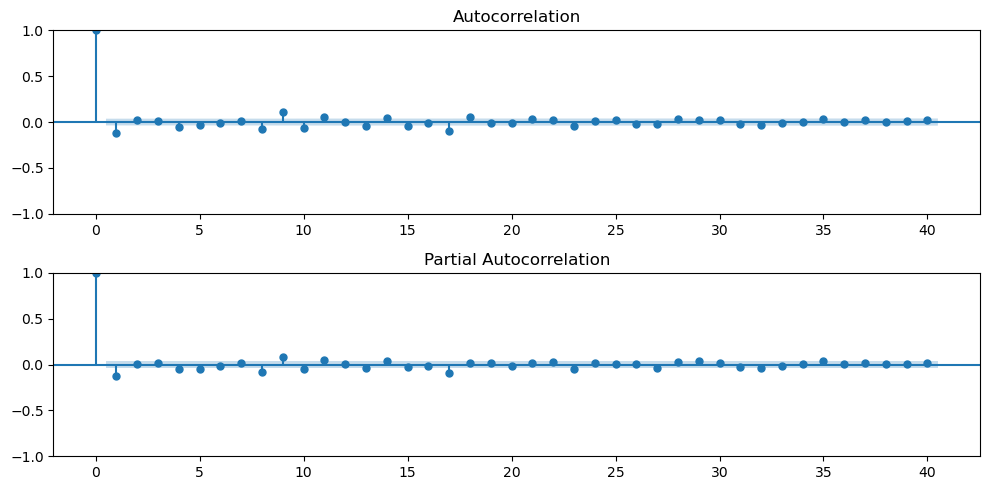

In [20]:
plot_acf_pacf(tsdiff);

*  There are no drop offs in either autocorrelation graphs.
*  Will use ARMA model with order (1,1,1)

### Create Model

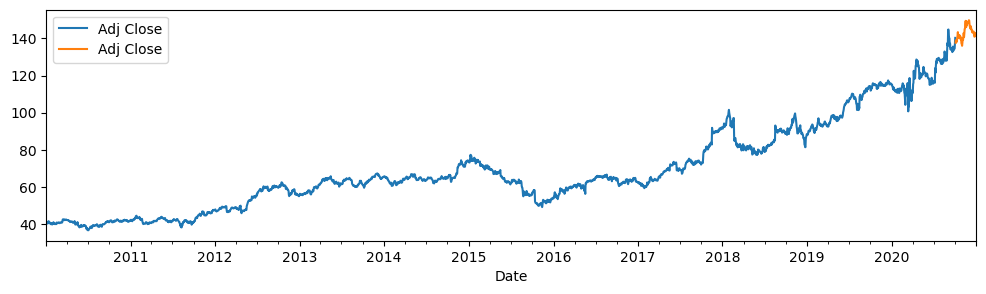

In [23]:
#Train Test Split data
# tts
quarter =13*5
train, test = train_test_split(ts, test_size=quarter)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();


In [47]:
# Define the orders (p,d,q)
p = 1
d = 1
q = 1

# Now instantiate the model with the data and fit
arma_model = tsa.ARIMA(train, order = (p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.744
- MSE = 22.319
- RMSE = 4.724
- R^2 = -0.736
- MAPE = 2.57%


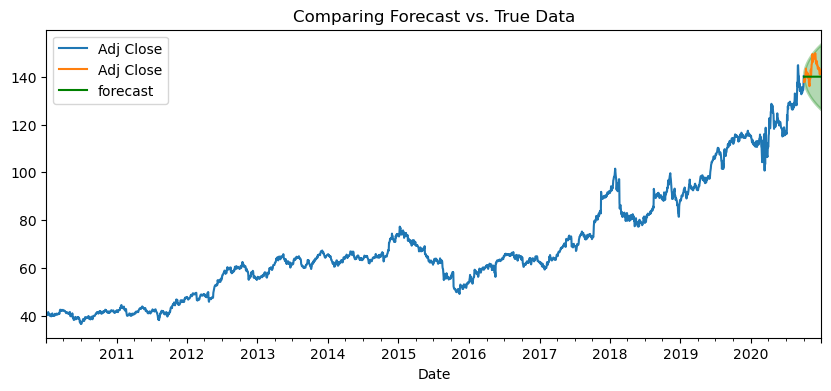

In [48]:
## Metrics

# Obtain summary of forecast as dataframe
forecast_df = arma_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [ ]:
#### Metrics/Evaluation of Model

In [27]:
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3887.572
Date:                Thu, 30 Nov 2023   AIC                           7781.144
Time:                        15:51:15   BIC                           7798.959
Sample:                    01-04-2010   HQIC                          7787.574
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1806      0.050     -3.634      0.000      -0.278      -0.083
ma.L1          0.0621      0.052      1.191      0.234      -0.040       0.164
sigma2         0.9380      0.006    146.421      0.000       0.925       0.951
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            113802.53
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              10.47   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

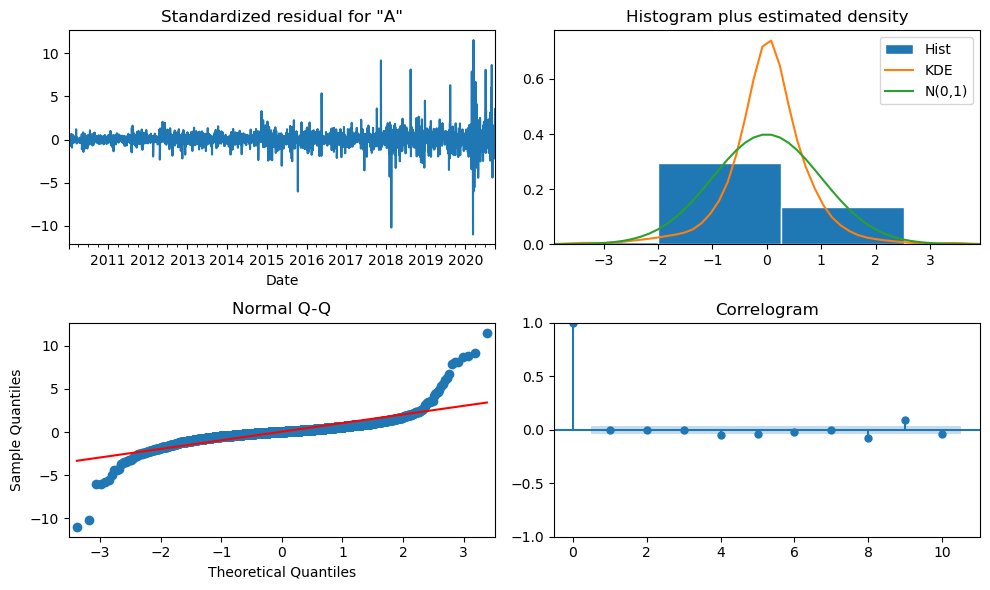

In [28]:
# Obtain diagnostic plots
fig = arma_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


** The metrics and plots show there is a skew in the data and the model did not capture all relevent data

### Test other models

In [33]:
#Define all possible values with itertools.product
### d has to remain constant to compare AIC

import itertools

# Define the value or range of values for p, d, q
p_values = range(1, 4)
d_values = [1]
q_values = range(1, 4)

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))

pdq_to_try



[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [38]:
# define starting aic as infinity
best_aic = float("inf")

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:

    model = tsa.ARIMA(train, order=pdq)

    result = model.fit()

    print(pdq, result.aic)

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)


(1, 1, 1) 7781.144092878053
(1, 1, 2) 7781.9434508626955
(1, 1, 3) 7778.2344064854715
(2, 1, 1) 7783.302024788493


C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7783.305210561528
(2, 1, 3) 7769.195764127727
(3, 1, 1) 7785.127596608432


C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7771.544984361613
(3, 1, 3) 7771.207915499571
Best AIC: 7769.195764127727
Best pdq: (2, 1, 3)


C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


*  Will try (2, 1, 3)

### Try (2,1,3) on model

In [45]:
# Define the orders (p,d,q)
p = 2
d = 1
q = 3

# Now instantiate the model with the data and fit
arma_model2 = tsa.ARIMA(train, order = (p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.144
- MSE = 26.204
- RMSE = 5.119
- R^2 = -1.038
- MAPE = 2.85%


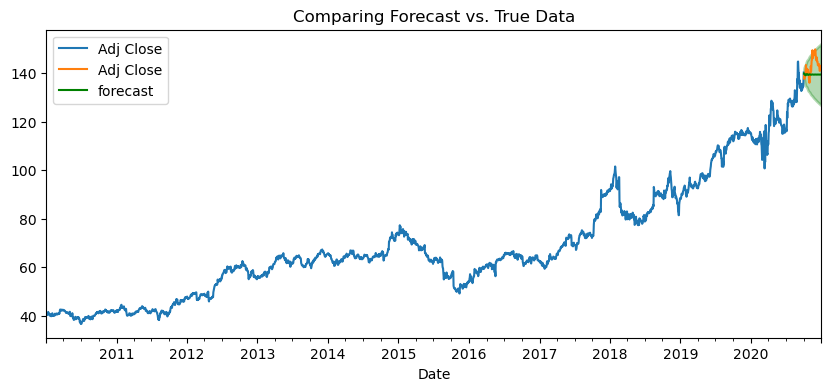

In [46]:
## Metrics

# Obtain summary of forecast as dataframe
forecast_df = arma_model2.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [49]:
arma_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3878.598
Date:                Thu, 30 Nov 2023   AIC                           7769.196
Time:                        16:16:10   BIC                           7804.826
Sample:                    01-04-2010   HQIC                          7782.056
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5164      0.042     35.837      0.000       1.433       1.599
ar.L2         -0.8593      0.042    -20.656      0.000      -0.941      -0.778
ma.L1         -1.6398      0.044    -37.395      0.000      -1.726      -1.554
ma.L2          1.0652      0.045     23.493      0.000       0.976       1.154
ma.L3         -0.1412      0.007    -19.938      0.000      -0.155      -0.127
sigma2         0.9320      0.007    133.642      0.000       0.918       0.946
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            106750.48
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              10.32   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

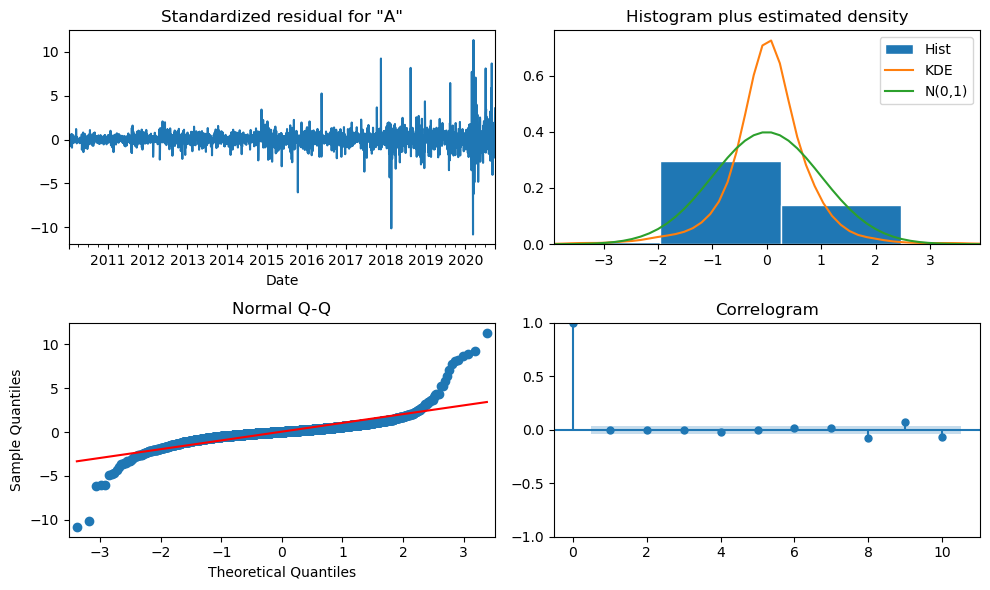

In [50]:
# Obtain diagnostic plots
fig = arma_model2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


* This model has the same skewness as the original
* There is a definate increase in the residual data
* MAPE is 2.85% which is higher that the 2.57% of the orignal model
* The AIC score for this model is lower for this model than the orignal model

### Final Evaluation

*  The original model with order (1,1,1) is the better model of these two.
*  It has the better MAPE score. Although it is still a little higher than 2%
*  

In [53]:
pred_df=arma_model.get_forecast(steps=len(test)).summary_frame()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

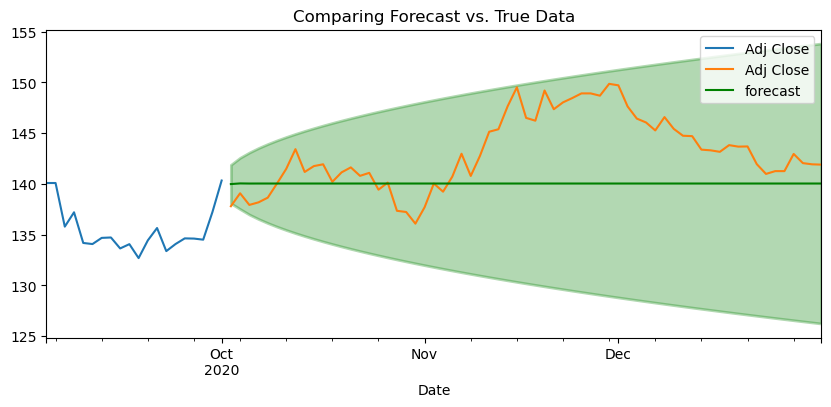

In [55]:
# use plot_forecast()

plot_forecast(train.tail(20), test, pred_df)

*  The testing data stays withing the shaded area of the graph, but doesn't follow the mean well